In [117]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import random
import math

In [ ]:
RANDOM_SEED = 69
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Clearing CUDA cache")
torch.cuda.empty_cache()

Using device: cuda
Clearing CUDA cache


## Part 1: Dataset Preparation
I'm loading the CIFAR-10 dataset, creating custom dataset classes, implementing data transformations, and setting up data loaders with an 80-20 train-validation split. I'm also adding visualization capabilities to explore sample images.

I referred to this paper regarding base augmentation and my experimental augmentation approach:

**A survey on Image Data Augmentation for Deep Learning**

[https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0)

In [119]:
class CIFAR10Dataset(Dataset):
    """Custom PyTorch Dataset for CIFAR-10"""
    
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

This new function highlights the differences between approaches taken over simple augmentation and slightly improved augmentation to add a bit more pizzaz

In [120]:
class CutoutTransform:
    """Cutout augmentation"""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length
        
    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W)
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out
        """
        h = img.size(1)
        w = img.size(2)
        
        mask = torch.ones((h, w), dtype=torch.float32)
        
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            
            mask[y1:y2, x1:x2] = 0.0
        
        mask = mask.expand_as(img)
        img = img * mask
        
        return img
    
def mixup_data(x, y, alpha=1.0):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [121]:
def prepare_cifar10_dataset(batch_size=64, augment=False):
    """
    Prepares the CIFAR-10 dataset for training and evaluation.
    
    Args:
        batch_size (int): Batch size for DataLoaders
        augment (bool): Whether to apply data augmentation to training data
    
    Returns:
        train_loader, val_loader, test_loader, class_names (tuple)
    """
    print("Loading CIFAR-10 dataset from Hugging Face...")
    
    dataset = load_dataset("cifar10")
    
    # Extract train and test sets
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    # Convert to numpy arrays
    X_train = np.array([np.array(image) for image in train_dataset['img']])
    y_train = np.array(train_dataset['label'])
    X_test = np.array([np.array(image) for image in test_dataset['img']])
    y_test = np.array(test_dataset['label'])
    
    print(f"Dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Define transformations based on whether augmentation is enabled
    if augment:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])
    
    # Create custom datasets
    train_data = CIFAR10Dataset(X_train, y_train, transform=train_transform)
    test_data = CIFAR10Dataset(X_test, y_test, transform=test_transform)
    
    # Split training data into train and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(RANDOM_SEED))
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2, pin_memory=True)
    
    # Define class names for reference
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    return train_loader, val_loader, test_loader, class_names

There are several "experimental" functions in the script that target a different approach for augmenting for the sake of covering all bases

In [156]:
def prepare_experimental_cifar10_dataset(batch_size=64, augment=False):
    """
    Prepares the CIFAR-10 dataset for training and evaluation.
    
    Args:
        batch_size (int): Batch size for DataLoaders
        augment (bool): Whether to apply data augmentation to training data
    
    Returns:
        train_loader, val_loader, test_loader, class_names (tuple)
    """
    print("Loading CIFAR-10 dataset from Hugging Face...")
    
    dataset = load_dataset("cifar10")
    
    # Extract train and test sets
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    # Convert to numpy arrays
    X_train = np.array([np.array(image) for image in train_dataset['img']])
    y_train = np.array(train_dataset['label'])
    X_test = np.array([np.array(image) for image in test_dataset['img']])
    y_test = np.array(test_dataset['label'])
    
    print(f"Dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Define transformations based on whether augmentation is enabled
    if augment:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, translate=(0.15, 0.15)),
            transforms.ToTensor(),
            CutoutTransform(n_holes=1, length=8),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

        # Create custom datasets
    train_data = CIFAR10Dataset(X_train, y_train, transform=train_transform)
    test_data = CIFAR10Dataset(X_test, y_test, transform=test_transform)
    
    # Split training data into train and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(RANDOM_SEED))
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    # Define class names for reference
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    return train_loader, val_loader, test_loader, class_names

In [123]:
def visualize_dataset_samples(loader, class_names, num_samples=5):
    """
    Visualize random samples from the dataset
    
    Args:
        loader: DataLoader containing the dataset
        class_names: List of class names
        num_samples: Number of samples to display
    """
    # Get a batch of images
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Create a grid to plot images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # Display images
    for i in range(num_samples):
        # Convert tensor to numpy array and transpose to correct dimensions
        image = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        image = image * 0.5 + 0.5
        # Clip to [0, 1] range
        image = np.clip(image, 0, 1)
        
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {class_names[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [124]:
def visualize_experimental_dataset_samples(loader, class_names, num_samples=5):
    """
    Visualize random samples from the dataset
    
    Args:
        loader: DataLoader containing the dataset
        class_names: List of class names
        num_samples: Number of samples to display
    """
    # Get a batch of images
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Create a grid to plot images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # Display images
    for i in range(num_samples):
        # Convert tensor to numpy array and transpose to correct dimensions
        image = images[i].permute(1, 2, 0).cpu().numpy()
        # Clip to [0, 1] range
        image = np.clip(image, 0, 1)
        
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {class_names[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Part 2: CNN Model Architecture
I'm defining a flexible CNN architecture for image classification with configurable parameters like number of layers, filters, and activation functions. The model includes convolutional layers with batch normalization, pooling, and fully connected layers with dropout for regularization.

In [125]:
class CIFAR10CNN(nn.Module):
    """
    CNN model for CIFAR-10 classification
    
    Args:
        num_filters (int): Initial number of filters in first conv layer
        num_conv_layers (int): Number of convolutional layers
        dropout_rate (float): Dropout rate for fully connected layers
        activation (str): Activation function to use ('relu', 'tanh', or 'sigmoid')
        kernel_size (int): Kernel size for convolutional layers
        conv_stride (int): Stride for convolutional layers
    """
    def __init__(self, num_filters=32, num_conv_layers=3, dropout_rate=0.3,
                 activation='relu', kernel_size=3, conv_stride=1):
        super(CIFAR10CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.activation = activation.lower()
        
        # Choose activation function
        if self.activation == 'relu':
            self.activation_fn = F.relu
        elif self.activation == 'tanh':
            self.activation_fn = torch.tanh
        elif self.activation == 'sigmoid':
            self.activation_fn = torch.sigmoid
        else:
            self.activation_fn = F.relu  # default
        
        # Set padding to keep same spatial dims (for odd kernel sizes)
        padding = kernel_size // 2
        
        # Build convolutional layers
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        # First conv layer: input channels 3 (RGB)
        self.conv_layers.append(nn.Conv2d(3, num_filters, kernel_size=kernel_size, 
                                         stride=conv_stride, padding=padding))
        self.batch_norms.append(nn.BatchNorm2d(num_filters))
        
        # Additional convolutional layers
        for i in range(1, num_conv_layers):
            in_channels = num_filters * (2**(i-1))
            out_channels = num_filters * (2**i)
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                                             stride=conv_stride, padding=padding))
            self.batch_norms.append(nn.BatchNorm2d(out_channels))
        
        # Calculate final feature map size after pooling
        # CIFAR images are 32x32, and each pooling reduces by factor of 2
        final_size = 32 // (2**num_conv_layers)
        # Make sure we don't end up with size 0 (use ceiling division)
        if final_size == 0:
            final_size = 1
        
        final_channels = num_filters * (2**(num_conv_layers-1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(final_channels * final_size * final_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)  # 10 classes in CIFAR-10
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        """Forward pass through the network"""
        # Pass through convolutional layers
        for i in range(self.num_conv_layers):
            x = self.conv_layers[i](x)
            x = self.batch_norms[i](x)
            x = self.activation_fn(x)
            x = F.max_pool2d(x, 2, ceil_mode=True)  # Use ceil mode to avoid size 0
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
class BasicBlock(nn.Module):
    """Basic residual block"""
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class CIFARCNN(nn.Module):
    """
    Enhanced CNN for CIFAR-10 with residual connections
    """
    def __init__(self, num_filters=32, num_blocks=2, dropout_rate=0.3):
        super(CIFARCNN, self).__init__()
        
        # Initial convolution
        self.in_planes = num_filters
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters)
        
        # Residual blocks
        self.layer1 = self._make_layer(BasicBlock, num_filters, num_blocks, stride=1)
        self.layer2 = self._make_layer(BasicBlock, num_filters*2, num_blocks, stride=2)
        self.layer3 = self._make_layer(BasicBlock, num_filters*4, num_blocks, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_filters*4 * 8 * 8, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)  # 10 classes in CIFAR-10
        self.dropout = nn.Dropout(dropout_rate)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial convolution
        out = F.relu(self.bn1(self.conv1(x)))
        
        # Residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Fully connected layers
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn_fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return F.log_softmax(out, dim=1)


In [127]:
def initialize_weights(model, init_method='he'):
    """
    Initialize model weights using specified method
    
    Args:
        model: PyTorch model
        init_method (str): Weight initialization method ('xavier' or 'he')
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if init_method.lower() == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif init_method.lower() == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [128]:
def initialize_experimental_weights(model):
    """
    Initialize model weights using He initialization
    
    Args:
        model: PyTorch model
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


## Part 3: Training and Evaluation Functions
I'm implementing the core training loop, validation, and testing functions. I've added early stopping to prevent overfitting and comprehensive evaluation metrics including accuracy, precision, recall, and F1-score. These functions form the backbone of my model training pipeline.

In [129]:
def get_optimizer(model, optimizer_name, lr):
    """
    Get optimizer based on name
    
    Args:
        model: PyTorch model
        optimizer_name (str): Name of optimizer ('adam', 'sgd', or 'rmsprop')
        lr (float): Learning rate
        
    Returns:
        PyTorch optimizer
    """
    if optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        return optim.Adam(model.parameters(), lr=lr)

In [130]:
def train(model, train_loader, optimizer, criterion, device):
    """
    Train model for one epoch
    
    Args:
        model: PyTorch model of my own fabulous design (I am lying)
        train_loader: DataLoader for training data
        optimizer: PyTorch optimizer
        criterion: Loss function
        device: Device to train on (CPU or GPU)
        
    Returns:
        average_loss, accuracy (tuple): Training loss and accuracy
    """
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    return running_loss / len(train_loader), 100. * correct / total

In [131]:
def train_experimental(model, train_loader, optimizer, criterion, device, use_mixup=True, mixup_alpha=0.2):
    """
    Train model for one epoch
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        optimizer: PyTorch optimizer
        criterion: Loss function
        device: Device to train on (CPU or GPU)
        use_mixup: Whether to use mixup
        mixup_alpha: Alpha parameter for mixup
        
    Returns:
        average_loss, accuracy (tuple): Training loss and accuracy
    """
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Apply mixup if enabled
        if use_mixup and mixup_alpha > 0:
            data, targets_a, targets_b, lam = mixup_data(data, target, mixup_alpha)
            # Forward pass
            output = model(data)
            # Calculate loss with mixup
            loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
            # For accuracy calculation with mixup
            _, predicted = output.max(1)
            correct += (lam * predicted.eq(targets_a).sum().float() + 
                      (1 - lam) * predicted.eq(targets_b).sum().float())
        else:
            # Forward pass
            output = model(data)
            # Calculate loss
            loss = criterion(output, target)
            # Track accuracy
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
        
        # Backward pass and optimize
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        total += target.size(0)
    
    return running_loss / len(train_loader), 100. * correct / total


In [133]:
def validate(model, val_loader, criterion, device):
    """
    Validate model on validation data
    
    Args:
        model: PyTorch model
        val_loader: DataLoader for validation data
        criterion: Loss function
        device: Device to validate on (CPU or GPU)
        
    Returns:
        average_loss, accuracy (tuple): Validation loss and accuracy
    """
    model.eval()
    val_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Track statistics
            val_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return val_loss / len(val_loader), 100. * correct / total

In [134]:
def test(model, test_loader, device):
    """
    Test model on test data
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        device: Device to test on (CPU or GPU)
        
    Returns:
        accuracy (float): Test accuracy
    """
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Track statistics
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return 100. * correct / total

In [135]:
class EarlyStopping:
    """
    Early stopping to prevent overfitting
    
    Args:
        patience (int): Number of epochs with no improvement after which training will be stopped
        min_delta (float): Minimum change in monitored quantity to qualify as improvement
        verbose (bool): Whether to print messages
    """
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        
    def __call__(self, val_loss, model):
        """
        Check if training should be stopped
        
        Args:
            val_loss (float): Validation loss
            model: PyTorch model to save if validation loss improves
        """
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        """
        Save model checkpoint
        
        Args:
            val_loss (float): Validation loss
            model: PyTorch model to save
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')

In [136]:
def train_model(model, train_loader, val_loader, learning_rate=0.001, epochs=50, 
               device='cuda', optimizer=None, patience=10):
    """
    Train model for specified number of epochs
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        learning_rate (float): Learning rate
        epochs (int): Number of epochs to train for
        device: Device to train on (CPU or GPU)
        optimizer: PyTorch optimizer (if None, Adam is used)
        patience (int): Patience for early stopping
        
    Returns:
        history, best_val_acc (tuple): Training history and best validation accuracy
    """
    criterion = nn.CrossEntropyLoss()
    
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train and validate for one epoch
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Adjust learning rate
        scheduler.step(val_loss)
        
        # Print epoch statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Track best validation accuracy
        best_val_acc = max(best_val_acc, val_acc)
        
        # Check if training should be stopped
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    return history, best_val_acc

In [137]:
def train_experimental_model(model, train_loader, val_loader, learning_rate=0.001, epochs=50, 
               device='cuda', patience=15, weight_decay=1e-5, 
               use_mixup=True, mixup_alpha=0.2):
    """
    Train model for specified number of epochs
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        learning_rate (float): Learning rate
        epochs (int): Number of epochs to train for
        device: Device to train on (CPU or GPU)
        patience (int): Patience for early stopping
        weight_decay (float): Weight decay for L2 regularization
        use_mixup (bool): Whether to use mixup augmentation
        mixup_alpha (float): Alpha parameter for mixup
        
    Returns:
        history, best_val_acc (tuple): Training history and best validation accuracy
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler (ReduceLROnPlateau - worked well in original implementation)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
    best_val_acc = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")
        
        # Train and validate for one epoch
        train_loss, train_acc = train_experimental(model, train_loader, optimizer, criterion, device, 
                                     use_mixup=use_mixup, mixup_alpha=mixup_alpha)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Adjust learning rate
        scheduler.step(val_loss)
        
        # Print epoch statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Track best validation accuracy
        best_val_acc = max(best_val_acc, val_acc)
        
        # Check if training should be stopped
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return history, best_val_acc

In [138]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Evaluate model on test data
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        device: Device to evaluate on (CPU or GPU)
        class_names: List of class names
        
    Returns:
        acc, precision, recall, f1, conf_matrix (tuple): Evaluation metrics
    """
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Get predictions
            preds = output.argmax(dim=1)
            
            # Store predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds, all_targets = np.array(all_preds), np.array(all_targets)
    
    # Calculate metrics
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return acc, precision, recall, f1, conf_matrix

In [139]:
def visualize_training_history(history):
    """
    Visualize training history
    
    Args:
        history (dict): Training history with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()
    
    # Plot training and validation accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [140]:
def visualize_experimental_training_history(history):
    """
    Visualize training history
    
    Args:
        history (dict): Training history with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'lr'
    """
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()
    
    # Plot training and validation accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    
    # Plot learning rate
    if 'lr' in history:
        ax3.plot(history['lr'], label='Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_yscale('log')
        ax3.legend()
    
    plt.tight_layout()
    plt.show()

In [141]:
def visualize_feature_maps(model, test_loader, device, num_filters=8):
    """
    Visualize feature maps from convolutional layers
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        device: Device to use (CPU or GPU)
        num_filters (int): Number of filters to visualize
    """
    # Get a batch of images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    
    # Get a single image
    image = images[0:1].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get activations from convolutional layers
    activations = []
    
    # Forward pass through each conv layer
    x = image
    for i in range(model.num_conv_layers):
        x = model.conv_layers[i](x)
        x = model.batch_norms[i](x)
        x = model.activation_fn(x)
        activations.append(x)
        x = F.max_pool2d(x, 2, ceil_mode=True)
    
    # Plot feature maps
    for i, activation in enumerate(activations):
        # Move activation to CPU and convert to numpy
        activation = activation[0].detach().cpu().numpy()
        
        # Determine number of filters to display (min of num_filters and actual filters)
        n_filters = min(num_filters, activation.shape[0])
        
        # Create a figure with subplots
        fig, axes = plt.subplots(2, n_filters // 2, figsize=(15, 6))
        axes = axes.flatten()
        
        # Plot each filter
        for j in range(n_filters):
            axes[j].imshow(activation[j], cmap='viridis')
            axes[j].set_title(f'Filter {j+1}')
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.suptitle(f'Feature Maps from Convolutional Layer {i+1}')
        plt.show()

## Part 4: Model Training and Evaluation
I'm training and comparing models with and without data augmentation. I visualize the training progress, evaluate model performance on test data, and create a comparison table to assess the impact of augmentation techniques on classification performance.

In [142]:
def run_standard_model_comparison():
    """Run comparison between models with and without data augmentation"""
    print("\n" + "="*80)
    print("Model Comparison: With vs. Without Data Augmentation")
    print("="*80)
    
    # Train model without data augmentation
    print("\nTraining model WITHOUT data augmentation")
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64, augment=False)
    
    # Visualize some samples
    print("\nSample images from the dataset:")
    visualize_dataset_samples(train_loader, class_names)
    
    # Initialize and train model
    model_without = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
    history_without, best_val_acc_without = train_model(
        model_without, train_loader, val_loader,
        learning_rate=0.001, epochs=25, device=device
    )
    
    # Visualize training history
    print("\nTraining history for model WITHOUT data augmentation:")
    visualize_training_history(history_without)
    
    # Evaluate model
    print("\nEvaluating model WITHOUT data augmentation on test data:")
    acc_wo, precision_wo, recall_wo, f1_wo, conf_matrix_wo = evaluate_model(
        model_without, test_loader, device, class_names
    )
    
    # Visualize feature maps
    print("\nFeature maps for model WITHOUT data augmentation:")
    visualize_feature_maps(model_without, test_loader, device)
    
    # Train model with data augmentation
    print("\nTraining model WITH data augmentation")
    train_loader_aug, val_loader_aug, test_loader_aug, class_names = prepare_cifar10_dataset(batch_size=64, augment=True)
    
    # Initialize and train model
    model_with = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
    history_with, best_val_acc_with = train_model(
        model_with, train_loader_aug, val_loader_aug,
        learning_rate=0.001, epochs=25, device=device
    )
    
    # Visualize training history
    print("\nTraining history for model WITH data augmentation:")
    visualize_training_history(history_with)
    
    # Evaluate model
    print("\nEvaluating model WITH data augmentation on test data:")
    acc_aug, precision_aug, recall_aug, f1_aug, conf_matrix_aug = evaluate_model(
        model_with, test_loader_aug, device, class_names
    )
    
    # Visualize feature maps
    print("\nFeature maps for model WITH data augmentation:")
    visualize_feature_maps(model_with, test_loader_aug, device)
    
    # Create a results table
    results = [
        {
            "Model": "Without Augmentation",
            "Accuracy": f"{acc_wo*100:.2f}%",
            "Precision": f"{precision_wo*100:.2f}%",
            "Recall": f"{recall_wo*100:.2f}%",
            "F1-Score": f"{f1_wo*100:.2f}%"
        },
        {
            "Model": "With Augmentation",
            "Accuracy": f"{acc_aug*100:.2f}%",
            "Precision": f"{precision_aug*100:.2f}%",
            "Recall": f"{recall_aug*100:.2f}%",
            "F1-Score": f"{f1_aug*100:.2f}%"
        }
    ]
    
    df_results = pd.DataFrame(results)
    print("\nTable 1: Performance Metrics Comparison of CNN Models")
    print(df_results.to_markdown(index=False))
    
    return model_without, model_with, history_without, history_with

In [ ]:
def run_i_mode():
    print("\n" + "="*80)
    print("Training Enhanced CNN for CIFAR-10")
    print("="*80)
    
    # Prepare dataset with enhanced augmentation
    train_loader, val_loader, test_loader, class_names = prepare_experimental_cifar10_dataset(batch_size=128, augment=True)
    
    # Visualize some samples
    print("\nSample images from the augmented dataset:")
    visualize_experimental_dataset_samples(train_loader, class_names)
    
    # Initialize the improved model
    model = CIFARCNN(num_filters=64, num_blocks=2, dropout_rate=0.3).to(device)
    initialize_experimental_weights(model)
    
    # Train model with improved techniques
    history, best_val_acc = train_experimental_model(
        model, train_loader, val_loader,
        learning_rate=0.001, epochs=70, device=device, patience=15, 
        weight_decay=1e-5, use_mixup=True, mixup_alpha=0.2
    )
    
    # Visualize training history
    print("\nTraining history:")
    visualize_experimental_training_history(history)
    
    # Evaluate model
    print("\nEvaluating model on test data:")
    acc, precision, recall, f1, _ = evaluate_model(
        model, test_loader, device, class_names
    )
    
    # Print final results
    print(f"\nFinal model performance:")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1-Score: {f1*100:.2f}%")
    
    return model, history

## Part 5: Hyperparameter Optimization using Random Search
I'm systematically exploring different model configurations by randomly sampling hyperparameters and evaluating their performance. This helps me identify the optimal combination of learning rate, network depth, filter counts, and other parameters to maximize model accuracy.

In [144]:
def random_search(num_trials=10, epochs=15):
    """
    Perform random search for hyperparameter optimization
    
    Args:
        num_trials (int): Number of trials to run
        epochs (int): Number of epochs for each trial
        
    Returns:
        results, best_params, best_model (tuple): Results, best hyperparameters, and best model
    """
    print("\n" + "="*80)
    print("Hyperparameter Optimization with Random Search")
    print("="*80)
    
    # Define hyperparameter search space
    param_grid = {
        "learning_rate": [0.001, 0.01, 0.1],
        "num_conv_layers": [3, 4, 5],
        "num_filters": [16, 32, 64],
        "batch_size": [32, 64, 128],
        "optimizer": ["adam", "sgd", "rmsprop"],
        "activation": ["relu", "tanh", "sigmoid"],
        "dropout_rate": [0.2, 0.3, 0.5],
        "kernel_size": [3, 5],
        "conv_stride": [1, 2],
        "weight_init": ["xavier", "he"]
    }
    
    results = []
    best_val_acc = 0
    best_params = None
    best_model = None
    
    # Load dataset once with data augmentation
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64, augment=True)
    
    for trial in range(num_trials):
        # Randomly sample hyperparameters
        lr = random.choice(param_grid["learning_rate"])
        num_layers = random.choice(param_grid["num_conv_layers"])
        num_filters = random.choice(param_grid["num_filters"])
        batch_size = random.choice(param_grid["batch_size"])
        optimizer_name = random.choice(param_grid["optimizer"])
        activation = random.choice(param_grid["activation"])
        dropout_rate = random.choice(param_grid["dropout_rate"])
        kernel_size = random.choice(param_grid["kernel_size"])
        conv_stride = random.choice(param_grid["conv_stride"])
        weight_init = random.choice(param_grid["weight_init"])
        
        # Create a model identifier string for logging
        model_id = (f"Trial {trial+1}: lr={lr}, layers={num_layers}, filters={num_filters}, "
                    f"bs={batch_size}, opt={optimizer_name}, act={activation}, dropout={dropout_rate}, "
                    f"kernel={kernel_size}, stride={conv_stride}, init={weight_init}")
        print(f"\nRunning {model_id}")
        
        # Reload data loaders if batch size changes
        if batch_size != train_loader.batch_size:
            train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(
                batch_size=batch_size, augment=True
            )
        
        try:
            # Initialize model with sampled hyperparameters
            model = CIFAR10CNN(
                num_filters=num_filters, 
                num_conv_layers=num_layers, 
                dropout_rate=dropout_rate,
                activation=activation, 
                kernel_size=kernel_size, 
                conv_stride=conv_stride
            ).to(device)
            
            # Initialize weights
            initialize_weights(model, weight_init)
            
            # Get optimizer
            optimizer = get_optimizer(model, optimizer_name, lr)
            
            # Train model
            history, val_acc = train_model(
                model, 
                train_loader, 
                val_loader,
                learning_rate=lr, 
                epochs=epochs, 
                device=device, 
                optimizer=optimizer,
                patience=5  # Reduced patience for faster trials
            )
            
            # Test model
            test_acc = test(model, test_loader, device)
            
            # Store results
            results.append({
                "Trial": trial + 1,
                "Learning Rate": lr,
                "Conv Layers": num_layers,
                "Filters": num_filters,
                "Batch Size": batch_size,
                "Optimizer": optimizer_name,
                "Activation": activation,
                "Dropout Rate": dropout_rate,
                "Kernel Size": kernel_size,
                "Stride": conv_stride,
                "Weight Init": weight_init,
                "Val Accuracy": f"{val_acc:.2f}%",
                "Test Accuracy": f"{test_acc:.2f}%"
            })
            
            # Track best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    "learning_rate": lr,
                    "num_conv_layers": num_layers,
                    "num_filters": num_filters,
                    "batch_size": batch_size,
                    "optimizer": optimizer_name,
                    "activation": activation,
                    "dropout_rate": dropout_rate,
                    "kernel_size": kernel_size,
                    "conv_stride": conv_stride,
                    "weight_init": weight_init
                }
                best_model = model
                
                # Save best model
                torch.save(model.state_dict(), 'best_model.pt')
                
        except Exception as e:
            print(f"Error in trial {trial+1}: {str(e)}")
            # Continue with next trial
            continue
    
    # Display results
    results_df = pd.DataFrame(results)
    print("\nHyperparameter Search Results:")
    print(results_df.to_markdown(index=False))
    
    print("\nBest hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    # Evaluate best model
    if best_model is not None:
        print("\nEvaluating best model on test data:")
        acc, precision, recall, f1, conf_matrix = evaluate_model(
            best_model, test_loader, device, class_names
        )
        
        print(f"\nBest model performance on test data:")
        print(f"Accuracy: {acc*100:.2f}%")
        print(f"Precision: {precision*100:.2f}%")
        print(f"Recall: {recall*100:.2f}%")
        print(f"F1-Score: {f1*100:.2f}%")
    
    return results, best_params, best_model

# Part 6: Main Execution

In [145]:
if __name__ == "__main__":
    torch.cuda.empty_cache()
    print("\nPreparing datasets...")
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64, augment=False)


Preparing datasets...
Loading CIFAR-10 dataset from Hugging Face...
Dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)



Visualizing sample images from the dataset:


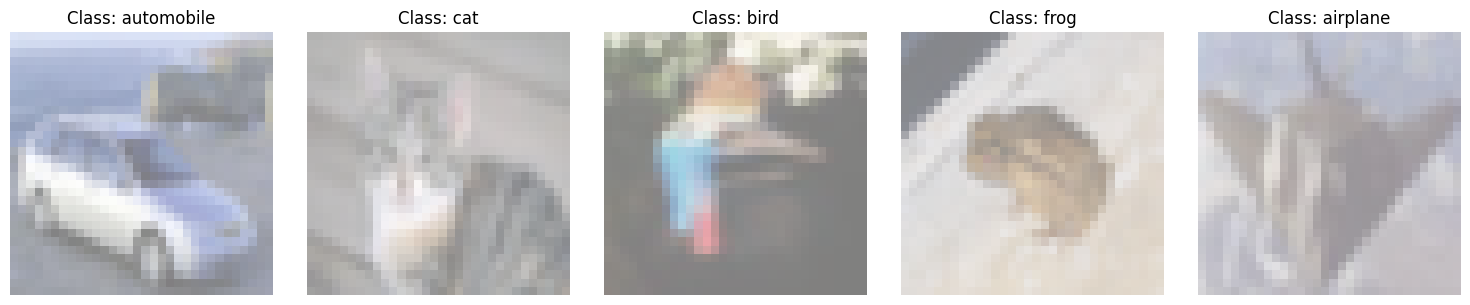

In [146]:
if __name__ == "__main__":
    print("\nVisualizing sample images from the dataset:")
    visualize_dataset_samples(train_loader, class_names)

In [147]:
if __name__ == "__main__":
    print("\nTraining model WITHOUT data augmentation")
    model_without = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
    history_without, best_val_acc_without = train_model(
        model_without, train_loader, val_loader,
        learning_rate=0.001, epochs=50, device=device
    )


Training model WITHOUT data augmentation

Epoch 1/50


/home/ibz/Projects/TensorLabs_Internship_Task/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.2008, Train Acc: 57.02%, Val Loss: 0.9896, Val Acc: 64.86%
Validation loss decreased (0.989576 --> 0.989576). Saving model...

Epoch 2/50
Train Loss: 0.8545, Train Acc: 69.81%, Val Loss: 0.8445, Val Acc: 69.69%
Validation loss decreased (0.844495 --> 0.844495). Saving model...

Epoch 3/50
Train Loss: 0.7090, Train Acc: 75.12%, Val Loss: 0.9566, Val Acc: 67.70%
EarlyStopping counter: 1 out of 10

Epoch 4/50
Train Loss: 0.5991, Train Acc: 78.99%, Val Loss: 0.8885, Val Acc: 69.50%
EarlyStopping counter: 2 out of 10

Epoch 5/50
Train Loss: 0.5043, Train Acc: 82.22%, Val Loss: 0.9429, Val Acc: 69.88%
EarlyStopping counter: 3 out of 10

Epoch 6/50
Train Loss: 0.4286, Train Acc: 84.88%, Val Loss: 0.8784, Val Acc: 72.24%
EarlyStopping counter: 4 out of 10

Epoch 7/50
Train Loss: 0.2741, Train Acc: 90.40%, Val Loss: 0.7748, Val Acc: 76.12%
Validation loss decreased (0.774845 --> 0.774845). Saving model...

Epoch 8/50
Train Loss: 0.2054, Train Acc: 92.88%, Val Loss: 0.7571, Val Acc


Visualizing training history:


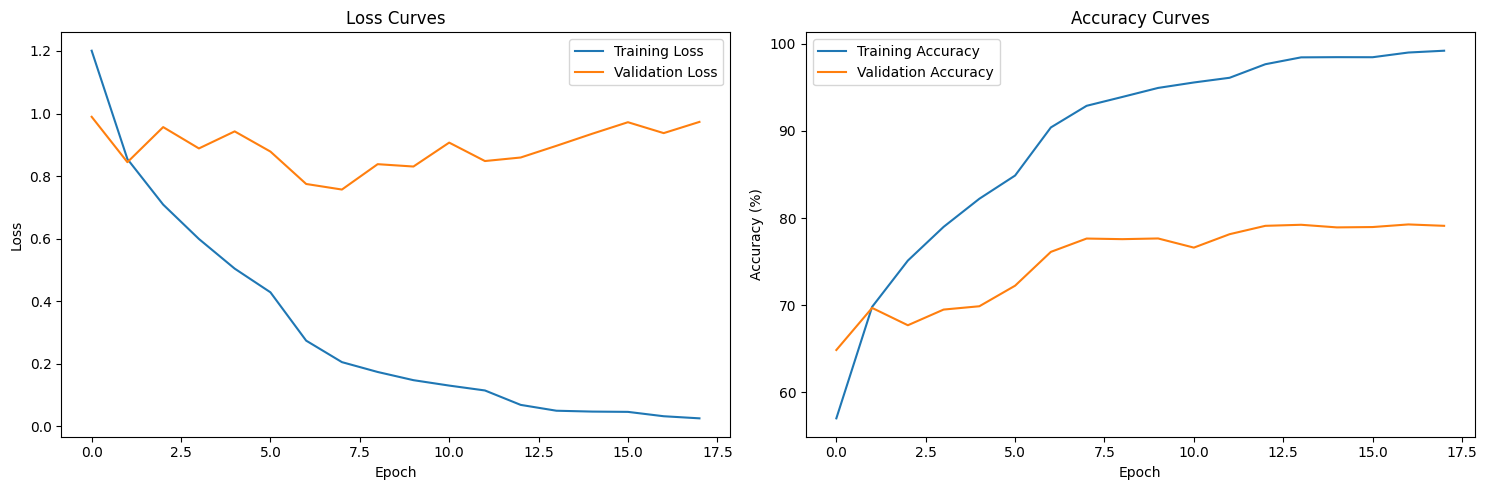

In [148]:
if __name__ == "__main__":
    print("\nVisualizing training history:")
    visualize_training_history(history_without)


Evaluating model on test data:


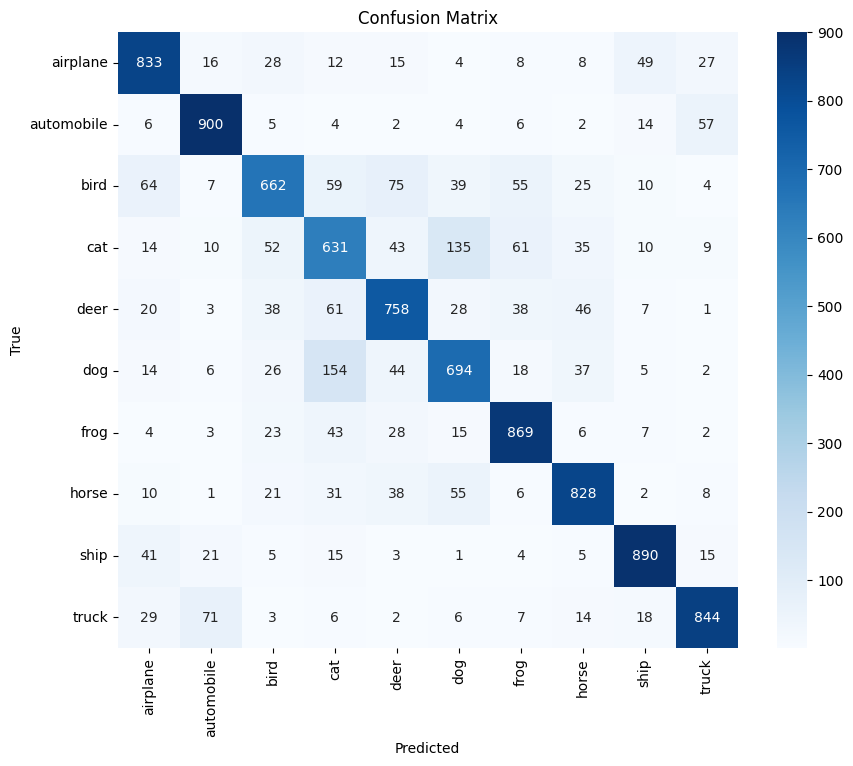

In [149]:
if __name__ == "__main__":
    print("\nEvaluating model on test data:")
    acc_wo, precision_wo, recall_wo, f1_wo, conf_matrix_wo = evaluate_model(
        model_without, test_loader, device, class_names
    )

In [150]:
if __name__ == "__main__":
    torch.cuda.empty_cache()
    print("\nTraining model WITH data augmentation")
    train_loader_aug, val_loader_aug, test_loader_aug, _ = prepare_cifar10_dataset(batch_size=64, augment=True)
    model_with = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
    history_with, best_val_acc_with = train_model(
        model_with, train_loader_aug, val_loader_aug,
        learning_rate=0.001, epochs=50, device=device
    )


Training model WITH data augmentation
Loading CIFAR-10 dataset from Hugging Face...
Dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

Epoch 1/50


/home/ibz/Projects/TensorLabs_Internship_Task/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.5000, Train Acc: 45.44%, Val Loss: 1.3966, Val Acc: 49.69%
Validation loss decreased (1.396619 --> 1.396619). Saving model...

Epoch 2/50
Train Loss: 1.1818, Train Acc: 57.66%, Val Loss: 1.2773, Val Acc: 55.61%
Validation loss decreased (1.277337 --> 1.277337). Saving model...

Epoch 3/50
Train Loss: 1.0546, Train Acc: 62.52%, Val Loss: 1.0248, Val Acc: 62.95%
Validation loss decreased (1.024798 --> 1.024798). Saving model...

Epoch 4/50
Train Loss: 0.9902, Train Acc: 64.91%, Val Loss: 0.9190, Val Acc: 67.00%
Validation loss decreased (0.918972 --> 0.918972). Saving model...

Epoch 5/50
Train Loss: 0.9291, Train Acc: 67.20%, Val Loss: 1.0211, Val Acc: 63.94%
EarlyStopping counter: 1 out of 10

Epoch 6/50
Train Loss: 0.8892, Train Acc: 68.66%, Val Loss: 0.8743, Val Acc: 68.81%
Validation loss decreased (0.874307 --> 0.874307). Saving model...

Epoch 7/50
Train Loss: 0.8529, Train Acc: 70.02%, Val Loss: 0.9094, Val Acc: 68.39%
EarlyStopping counter: 1 out of 10

Epoch 8/50



Visualizing training history with augmentation:


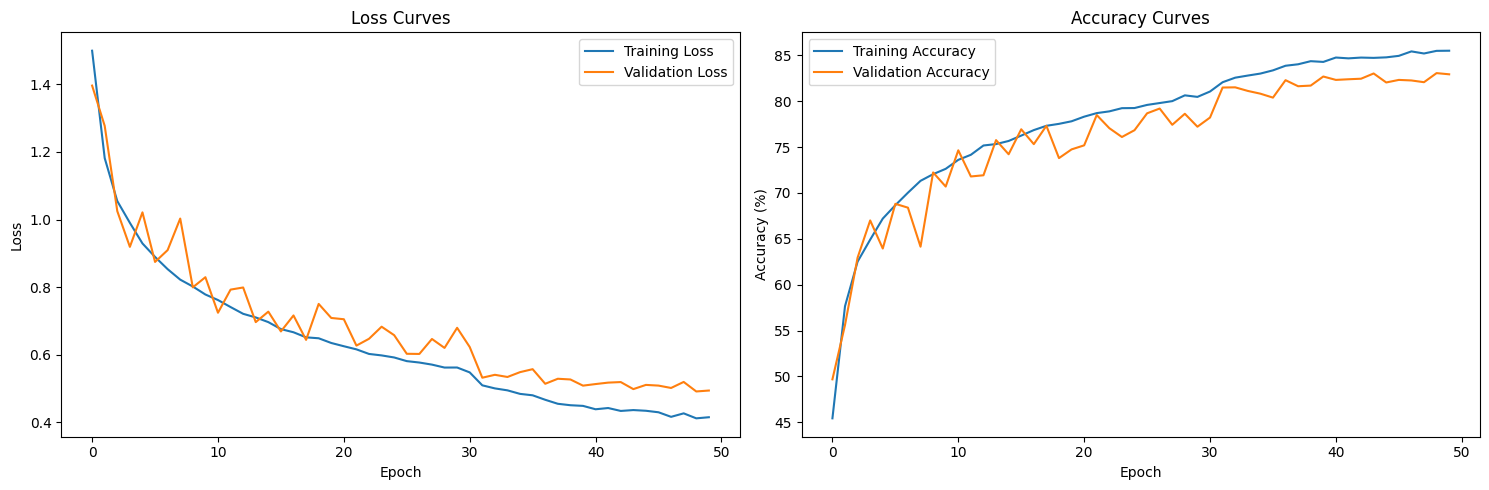

In [151]:
if __name__ == "__main__":
    print("\nVisualizing training history with augmentation:")
    visualize_training_history(history_with)


Evaluating model with augmentation:


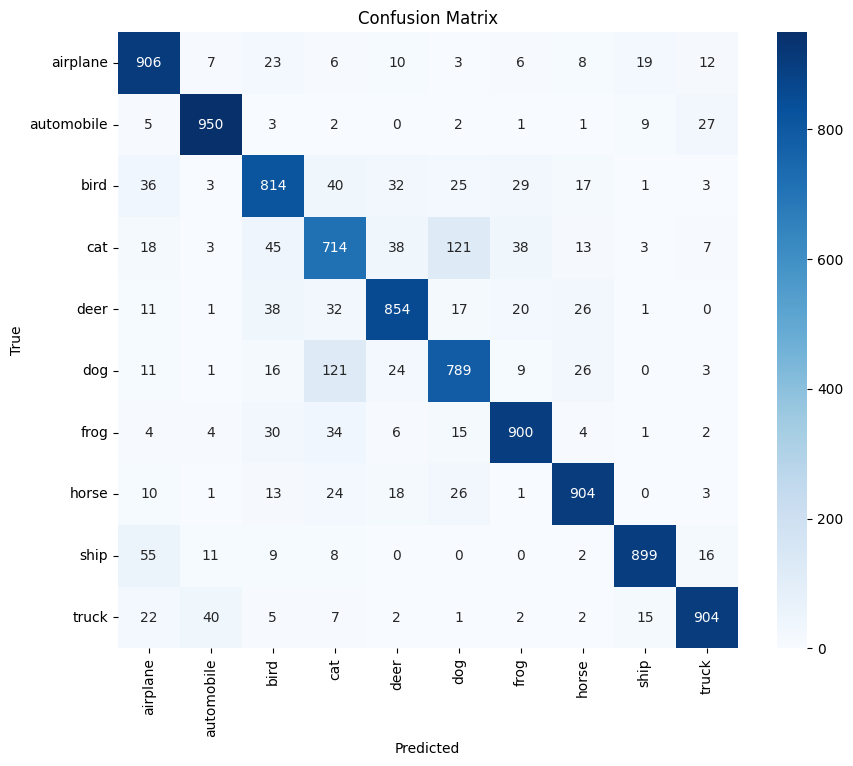

In [152]:
if __name__ == "__main__":
    print("\nEvaluating model with augmentation:")
    acc_aug, precision_aug, recall_aug, f1_aug, conf_matrix_aug = evaluate_model(
        model_with, test_loader_aug, device, class_names
    )

In [153]:
if __name__ == "__main__":
    # Create results table
    results = [
        {
            "Model": "Without Augmentation",
            "Accuracy": f"{acc_wo*100:.2f}%",
            "Precision": f"{precision_wo*100:.2f}%",
            "Recall": f"{recall_wo*100:.2f}%",
            "F1-Score": f"{f1_wo*100:.2f}%"
        },
        {
            "Model": "With Augmentation",
            "Accuracy": f"{acc_aug*100:.2f}%",
            "Precision": f"{precision_aug*100:.2f}%",
            "Recall": f"{recall_aug*100:.2f}%",
            "F1-Score": f"{f1_aug*100:.2f}%"
        }
    ]
    
    df_results = pd.DataFrame(results)
    print("\nTable 1: Performance Metrics Comparison of CNN Models")
    print(df_results.to_markdown(index=False))


Table 1: Performance Metrics Comparison of CNN Models
| Model                | Accuracy   | Precision   | Recall   | F1-Score   |
|:---------------------|:-----------|:------------|:---------|:-----------|
| Without Augmentation | 79.09%     | 79.04%      | 79.09%   | 79.01%     |
| With Augmentation    | 86.34%     | 86.38%      | 86.34%   | 86.34%     |


I added another experimental augmentation approach to further explore the effect it has and learn more about it

Starting CIFAR-10 classification with enhanced CNN

Training Enhanced CNN for CIFAR-10
Loading CIFAR-10 dataset from Hugging Face...
Dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

Sample images from the augmented dataset:


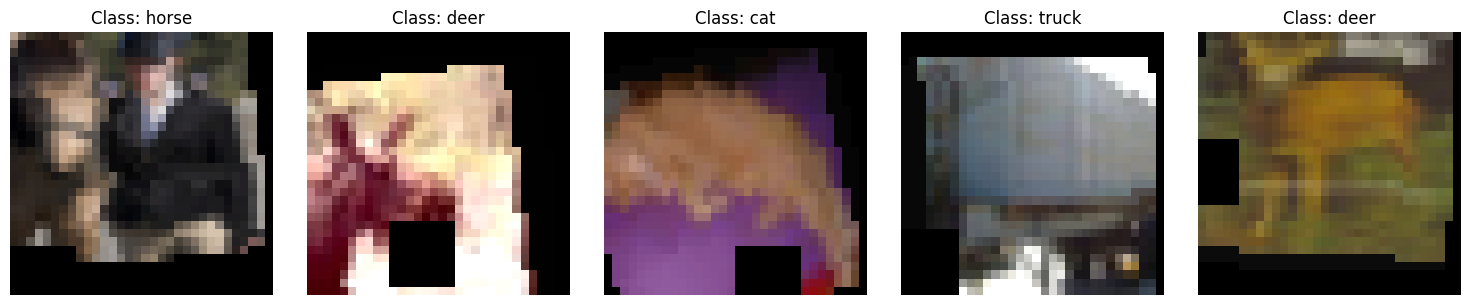


Epoch 1/70
Learning rate: 0.001000


/home/ibz/Projects/TensorLabs_Internship_Task/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 2.8322, Train Acc: 23.49%, Val Loss: 4.3717, Val Acc: 27.77%
Validation loss decreased (4.371738 --> 4.371738). Saving model...

Epoch 2/70
Learning rate: 0.001000
Train Loss: 2.1325, Train Acc: 34.50%, Val Loss: 1.9990, Val Acc: 42.57%
Validation loss decreased (1.998999 --> 1.998999). Saving model...

Epoch 3/70
Learning rate: 0.001000
Train Loss: 1.9682, Train Acc: 40.92%, Val Loss: 2.6168, Val Acc: 43.77%
EarlyStopping counter: 1 out of 15

Epoch 4/70
Learning rate: 0.001000
Train Loss: 1.8788, Train Acc: 44.81%, Val Loss: 2.8712, Val Acc: 46.77%
EarlyStopping counter: 2 out of 15

Epoch 5/70
Learning rate: 0.001000
Train Loss: 1.7884, Train Acc: 48.24%, Val Loss: 8.6305, Val Acc: 51.13%
EarlyStopping counter: 3 out of 15

Epoch 6/70
Learning rate: 0.001000
Train Loss: 1.7403, Train Acc: 49.79%, Val Loss: 1.7959, Val Acc: 53.87%
Validation loss decreased (1.795948 --> 1.795948). Saving model...

Epoch 7/70
Learning rate: 0.001000
Train Loss: 1.6537, Train Acc: 52.48%, V

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

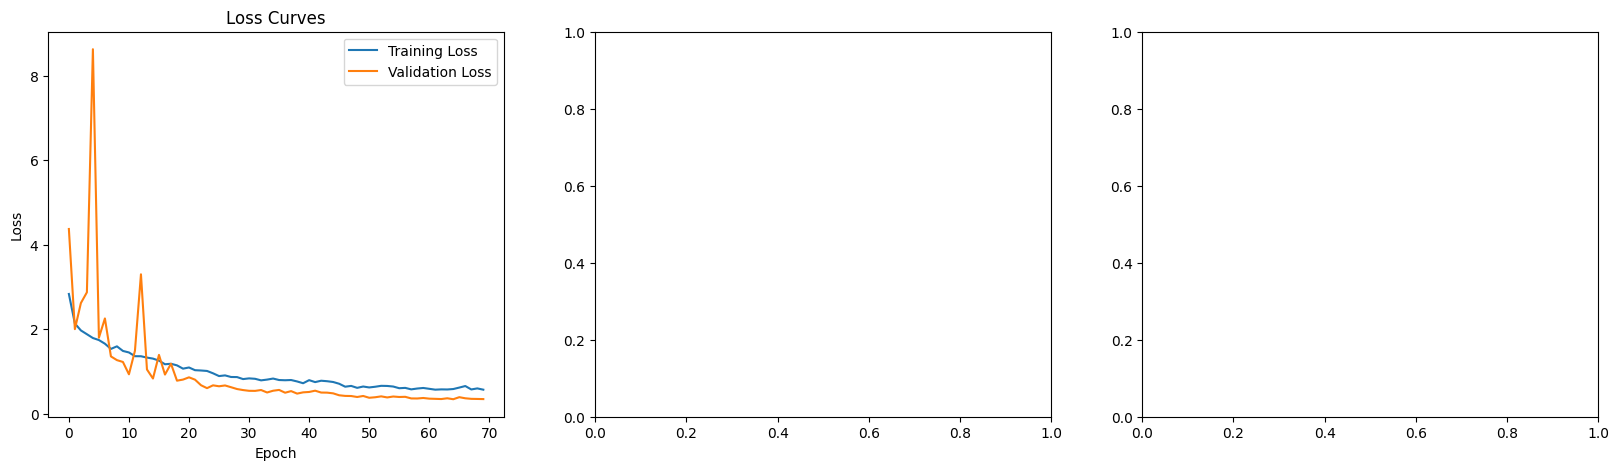

In [ ]:
if __name__ == "__main__":
    print("I added another experimental augmentation approach to further explore the effect it has and learn more about it")
    print("\nStarting CIFAR-10 classification with enhanced CNN")
    
    # For reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Run the improved model
    model, history = run_i_mode()
    
    print("\nExperiment complete!")

Output before my cuda messed up for visualizations


Train Loss: 2.8322, Train Acc: 23.49%, Val Loss: 4.3717, Val Acc: 27.77%
Validation loss decreased (4.371738 --> 4.371738). Saving model...

Epoch 2/70
Learning rate: 0.001000
Train Loss: 2.1325, Train Acc: 34.50%, Val Loss: 1.9990, Val Acc: 42.57%
Validation loss decreased (1.998999 --> 1.998999). Saving model...

Epoch 3/70
Learning rate: 0.001000
Train Loss: 1.9682, Train Acc: 40.92%, Val Loss: 2.6168, Val Acc: 43.77%
EarlyStopping counter: 1 out of 15

Epoch 4/70
Learning rate: 0.001000
Train Loss: 1.8788, Train Acc: 44.81%, Val Loss: 2.8712, Val Acc: 46.77%
EarlyStopping counter: 2 out of 15

Epoch 5/70
Learning rate: 0.001000
Train Loss: 1.7884, Train Acc: 48.24%, Val Loss: 8.6305, Val Acc: 51.13%
EarlyStopping counter: 3 out of 15

Epoch 6/70
Learning rate: 0.001000
Train Loss: 1.7403, Train Acc: 49.79%, Val Loss: 1.7959, Val Acc: 53.87%
Validation loss decreased (1.795948 --> 1.795948). Saving model...

Epoch 7/70
Learning rate: 0.001000
Train Loss: 1.6537, Train Acc: 52.48%, Val Loss: 2.2525, Val Acc: 58.51%
EarlyStopping counter: 1 out of 15

Epoch 8/70
Learning rate: 0.001000
Train Loss: 1.5303, Train Acc: 55.73%, Val Loss: 1.3528, Val Acc: 62.58%
Validation loss decreased (1.352835 --> 1.352835). Saving model...

Epoch 9/70
Learning rate: 0.001000
Train Loss: 1.5912, Train Acc: 56.94%, Val Loss: 1.2648, Val Acc: 63.41%
Validation loss decreased (1.264776 --> 1.264776). Saving model...

Epoch 10/70
Learning rate: 0.001000
Train Loss: 1.4822, Train Acc: 58.51%, Val Loss: 1.2210, Val Acc: 61.41%
Validation loss decreased (1.221000 --> 1.221000). Saving model...

Epoch 11/70
Learning rate: 0.001000
Train Loss: 1.4463, Train Acc: 60.64%, Val Loss: 0.9292, Val Acc: 68.23%
Validation loss decreased (0.929197 --> 0.929197). Saving model...

Epoch 12/70
Learning rate: 0.001000
Train Loss: 1.3577, Train Acc: 62.00%, Val Loss: 1.4863, Val Acc: 65.75%
EarlyStopping counter: 1 out of 15

Epoch 13/70
Learning rate: 0.001000
Train Loss: 1.3568, Train Acc: 61.66%, Val Loss: 3.2981, Val Acc: 67.98%
EarlyStopping counter: 2 out of 15

Epoch 14/70
Learning rate: 0.001000
Train Loss: 1.3247, Train Acc: 63.12%, Val Loss: 1.0436, Val Acc: 69.59%
EarlyStopping counter: 3 out of 15

Epoch 15/70
Learning rate: 0.001000
Train Loss: 1.3009, Train Acc: 64.15%, Val Loss: 0.8288, Val Acc: 73.33%
Validation loss decreased (0.828779 --> 0.828779). Saving model...

Epoch 16/70
Learning rate: 0.001000
Train Loss: 1.2532, Train Acc: 64.67%, Val Loss: 1.3893, Val Acc: 68.54%
EarlyStopping counter: 1 out of 15

Epoch 17/70
Learning rate: 0.001000
Train Loss: 1.1670, Train Acc: 66.17%, Val Loss: 0.9226, Val Acc: 69.09%
EarlyStopping counter: 2 out of 15

Epoch 18/70
Learning rate: 0.001000
Train Loss: 1.1783, Train Acc: 66.28%, Val Loss: 1.1793, Val Acc: 71.92%
EarlyStopping counter: 3 out of 15

Epoch 19/70
Learning rate: 0.001000
Train Loss: 1.1408, Train Acc: 67.05%, Val Loss: 0.7779, Val Acc: 75.27%
Validation loss decreased (0.777859 --> 0.777859). Saving model...

Epoch 20/70
Learning rate: 0.001000
Train Loss: 1.0628, Train Acc: 69.12%, Val Loss: 0.8037, Val Acc: 73.81%
EarlyStopping counter: 1 out of 15

Epoch 21/70
Learning rate: 0.001000
Train Loss: 1.0905, Train Acc: 68.50%, Val Loss: 0.8572, Val Acc: 75.14%
EarlyStopping counter: 2 out of 15

Epoch 22/70
Learning rate: 0.001000
Train Loss: 1.0263, Train Acc: 69.91%, Val Loss: 0.8018, Val Acc: 73.04%
EarlyStopping counter: 3 out of 15

Epoch 23/70
Learning rate: 0.001000
Train Loss: 1.0190, Train Acc: 69.97%, Val Loss: 0.6699, Val Acc: 77.63%
Validation loss decreased (0.669939 --> 0.669939). Saving model...

Epoch 24/70
Learning rate: 0.001000
Train Loss: 1.0084, Train Acc: 70.02%, Val Loss: 0.6007, Val Acc: 80.19%
Validation loss decreased (0.600725 --> 0.600725). Saving model...

Epoch 25/70
Learning rate: 0.001000
Train Loss: 0.9526, Train Acc: 71.40%, Val Loss: 0.6674, Val Acc: 77.66%
EarlyStopping counter: 1 out of 15

Epoch 26/70
Learning rate: 0.001000
Train Loss: 0.8869, Train Acc: 73.57%, Val Loss: 0.6452, Val Acc: 79.61%
EarlyStopping counter: 2 out of 15

Epoch 27/70
Learning rate: 0.001000
Train Loss: 0.9030, Train Acc: 73.26%, Val Loss: 0.6646, Val Acc: 78.14%
EarlyStopping counter: 3 out of 15

Epoch 28/70
Learning rate: 0.001000
Train Loss: 0.8653, Train Acc: 74.54%, Val Loss: 0.6230, Val Acc: 79.57%
EarlyStopping counter: 4 out of 15

Epoch 29/70
Learning rate: 0.001000
Train Loss: 0.8632, Train Acc: 74.26%, Val Loss: 0.5798, Val Acc: 80.87%
Validation loss decreased (0.579794 --> 0.579794). Saving model...

Epoch 30/70
Learning rate: 0.001000
Train Loss: 0.8156, Train Acc: 75.52%, Val Loss: 0.5553, Val Acc: 81.66%
Validation loss decreased (0.555338 --> 0.555338). Saving model...

Epoch 31/70
Learning rate: 0.001000
Train Loss: 0.8323, Train Acc: 75.39%, Val Loss: 0.5378, Val Acc: 81.44%
Validation loss decreased (0.537822 --> 0.537822). Saving model...

Epoch 32/70
Learning rate: 0.001000
Train Loss: 0.8225, Train Acc: 75.26%, Val Loss: 0.5362, Val Acc: 82.40%
Validation loss decreased (0.536216 --> 0.536216). Saving model...

Epoch 33/70
Learning rate: 0.001000
Train Loss: 0.7854, Train Acc: 76.39%, Val Loss: 0.5564, Val Acc: 81.80%
EarlyStopping counter: 1 out of 15

Epoch 34/70
Learning rate: 0.001000
Train Loss: 0.8033, Train Acc: 75.90%, Val Loss: 0.4981, Val Acc: 83.57%
Validation loss decreased (0.498112 --> 0.498112). Saving model...

Epoch 35/70
Learning rate: 0.001000
Train Loss: 0.8282, Train Acc: 75.33%, Val Loss: 0.5396, Val Acc: 82.81%
EarlyStopping counter: 1 out of 15

Epoch 36/70
Learning rate: 0.001000
Train Loss: 0.7932, Train Acc: 76.95%, Val Loss: 0.5588, Val Acc: 82.06%
EarlyStopping counter: 2 out of 15

Epoch 37/70
Learning rate: 0.001000
Train Loss: 0.7881, Train Acc: 76.59%, Val Loss: 0.4927, Val Acc: 84.40%
Validation loss decreased (0.492741 --> 0.492741). Saving model...

Epoch 38/70
Learning rate: 0.001000
Train Loss: 0.7934, Train Acc: 76.97%, Val Loss: 0.5306, Val Acc: 82.27%
EarlyStopping counter: 1 out of 15

Epoch 39/70
Learning rate: 0.001000
Train Loss: 0.7595, Train Acc: 77.77%, Val Loss: 0.4716, Val Acc: 85.01%
Validation loss decreased (0.471605 --> 0.471605). Saving model...

Epoch 40/70
Learning rate: 0.001000
Train Loss: 0.7173, Train Acc: 78.91%, Val Loss: 0.5014, Val Acc: 83.69%
EarlyStopping counter: 1 out of 15

Epoch 41/70
Learning rate: 0.001000
Train Loss: 0.7903, Train Acc: 77.25%, Val Loss: 0.5104, Val Acc: 84.44%
EarlyStopping counter: 2 out of 15

Epoch 42/70
Learning rate: 0.001000
Train Loss: 0.7442, Train Acc: 77.96%, Val Loss: 0.5409, Val Acc: 83.98%
EarlyStopping counter: 3 out of 15

Epoch 43/70
Learning rate: 0.001000
Train Loss: 0.7766, Train Acc: 76.88%, Val Loss: 0.4966, Val Acc: 84.05%
EarlyStopping counter: 4 out of 15

Epoch 44/70
Learning rate: 0.001000
Train Loss: 0.7651, Train Acc: 77.74%, Val Loss: 0.4944, Val Acc: 84.07%
EarlyStopping counter: 5 out of 15

Epoch 45/70
Learning rate: 0.001000
Train Loss: 0.7466, Train Acc: 78.05%, Val Loss: 0.4777, Val Acc: 84.71%
EarlyStopping counter: 6 out of 15

Epoch 46/70
Learning rate: 0.000500
Train Loss: 0.7051, Train Acc: 79.51%, Val Loss: 0.4320, Val Acc: 86.44%
Validation loss decreased (0.432029 --> 0.432029). Saving model...

Epoch 47/70
Learning rate: 0.000500
Train Loss: 0.6354, Train Acc: 81.57%, Val Loss: 0.4171, Val Acc: 86.83%
Validation loss decreased (0.417100 --> 0.417100). Saving model...

Epoch 48/70
Learning rate: 0.000500
Train Loss: 0.6539, Train Acc: 81.25%, Val Loss: 0.4143, Val Acc: 86.96%
Validation loss decreased (0.414251 --> 0.414251). Saving model...

Epoch 49/70
Learning rate: 0.000500
Train Loss: 0.6078, Train Acc: 82.55%, Val Loss: 0.3914, Val Acc: 86.64%
Validation loss decreased (0.391386 --> 0.391386). Saving model...

Epoch 50/70
Learning rate: 0.000500
Train Loss: 0.6395, Train Acc: 81.79%, Val Loss: 0.4154, Val Acc: 86.81%
EarlyStopping counter: 1 out of 15

Epoch 51/70
Learning rate: 0.000500
Train Loss: 0.6175, Train Acc: 82.40%, Val Loss: 0.3731, Val Acc: 87.89%
Validation loss decreased (0.373061 --> 0.373061). Saving model...

Epoch 52/70
Learning rate: 0.000500
Train Loss: 0.6341, Train Acc: 82.15%, Val Loss: 0.3852, Val Acc: 87.22%
EarlyStopping counter: 1 out of 15

Epoch 53/70
Learning rate: 0.000500
Train Loss: 0.6558, Train Acc: 81.57%, Val Loss: 0.4063, Val Acc: 86.86%
EarlyStopping counter: 2 out of 15

Epoch 54/70
Learning rate: 0.000500
Train Loss: 0.6529, Train Acc: 81.51%, Val Loss: 0.3809, Val Acc: 87.86%
EarlyStopping counter: 3 out of 15

Epoch 55/70
Learning rate: 0.000500
Train Loss: 0.6392, Train Acc: 81.79%, Val Loss: 0.4025, Val Acc: 87.06%
EarlyStopping counter: 4 out of 15

Epoch 56/70
Learning rate: 0.000500
Train Loss: 0.5993, Train Acc: 83.21%, Val Loss: 0.3914, Val Acc: 87.93%
EarlyStopping counter: 5 out of 15

Epoch 57/70
Learning rate: 0.000500
Train Loss: 0.6070, Train Acc: 82.82%, Val Loss: 0.3954, Val Acc: 87.35%
EarlyStopping counter: 6 out of 15

Epoch 58/70
Learning rate: 0.000250
Train Loss: 0.5722, Train Acc: 84.25%, Val Loss: 0.3572, Val Acc: 88.93%
Validation loss decreased (0.357248 --> 0.357248). Saving model...

Epoch 59/70
Learning rate: 0.000250
Train Loss: 0.5919, Train Acc: 83.45%, Val Loss: 0.3559, Val Acc: 88.87%
Validation loss decreased (0.355900 --> 0.355900). Saving model...

Epoch 60/70
Learning rate: 0.000250
Train Loss: 0.6052, Train Acc: 83.21%, Val Loss: 0.3678, Val Acc: 88.95%
EarlyStopping counter: 1 out of 15

Epoch 61/70
Learning rate: 0.000250
Train Loss: 0.5852, Train Acc: 83.46%, Val Loss: 0.3520, Val Acc: 89.02%
Validation loss decreased (0.352010 --> 0.352010). Saving model...

Epoch 62/70
Learning rate: 0.000250
Train Loss: 0.5650, Train Acc: 84.41%, Val Loss: 0.3476, Val Acc: 88.61%
Validation loss decreased (0.347627 --> 0.347627). Saving model...

Epoch 63/70
Learning rate: 0.000250
Train Loss: 0.5717, Train Acc: 83.70%, Val Loss: 0.3428, Val Acc: 88.73%
Validation loss decreased (0.342808 --> 0.342808). Saving model...

Epoch 64/70
Learning rate: 0.000250
Train Loss: 0.5696, Train Acc: 84.02%, Val Loss: 0.3607, Val Acc: 88.69%
EarlyStopping counter: 1 out of 15

Epoch 65/70
Learning rate: 0.000250
Train Loss: 0.5799, Train Acc: 83.77%, Val Loss: 0.3385, Val Acc: 89.23%
Validation loss decreased (0.338532 --> 0.338532). Saving model...

Epoch 66/70
Learning rate: 0.000250
Train Loss: 0.6145, Train Acc: 82.77%, Val Loss: 0.3868, Val Acc: 88.94%
EarlyStopping counter: 1 out of 15

Epoch 67/70
Learning rate: 0.000250
Train Loss: 0.6510, Train Acc: 81.53%, Val Loss: 0.3606, Val Acc: 89.30%
EarlyStopping counter: 2 out of 15

Epoch 68/70
Learning rate: 0.000250
Train Loss: 0.5703, Train Acc: 84.38%, Val Loss: 0.3475, Val Acc: 89.33%
EarlyStopping counter: 3 out of 15

Epoch 69/70
Learning rate: 0.000250
Train Loss: 0.5947, Train Acc: 83.33%, Val Loss: 0.3449, Val Acc: 89.12%
EarlyStopping counter: 4 out of 15

Epoch 70/70
Learning rate: 0.000250
Train Loss: 0.5647, Train Acc: 84.28%, Val Loss: 0.3417, Val Acc: 88.73%
EarlyStopping counter: 5 out of 15


Running hyperparameter optimization:

Hyperparameter Optimization with Random Search
Loading CIFAR-10 dataset from Hugging Face...
Dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

Running Trial 1: lr=0.1, layers=3, filters=16, bs=32, opt=adam, act=sigmoid, dropout=0.3, kernel=5, stride=2, init=he
Loading CIFAR-10 dataset from Hugging Face...
Dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

Epoch 1/5
Error in trial 1: mat1 and mat2 shapes cannot be multiplied (32x64 and 1024x512)

Running Trial 2: lr=0.01, layers=5, filters=32, bs=128, opt=sgd, act=sigmoid, dropout=0.5, kernel=5, stride=1, init=he
Loading CIFAR-10 dataset from Hugging Face...
Dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

Epoch 1/5
Train Loss: 2.0632, Train Acc: 23.86%, Val Loss: 2.5789, Val Acc: 22.10%
Validation loss decreased (2.578891 -

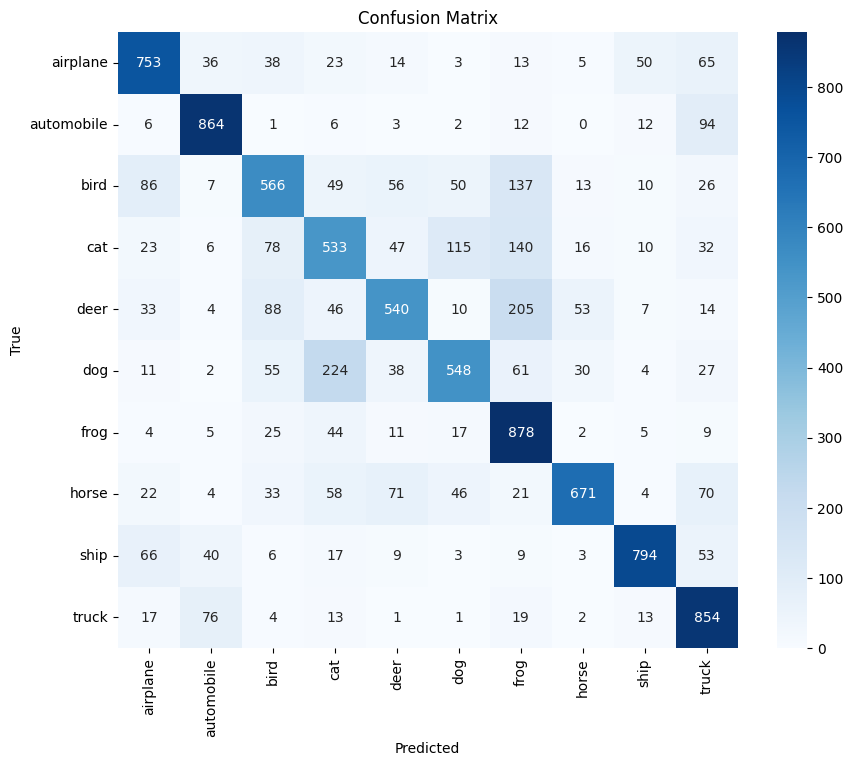


Best model performance on test data:
Accuracy: 70.01%
Precision: 70.89%
Recall: 70.01%
F1-Score: 69.76%


In [158]:
if __name__ == "__main__":
    torch.cuda.empty_cache()
    print("\nRunning hyperparameter optimization:")
    results, best_params, best_model = random_search(num_trials=3, epochs=5)